In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.python.keras.layers import Dense, LSTM , Dropout
from tensorflow.python.keras import Sequential
from math import sqrt;

**DATASET PREPROCESSING**




Dataset Loading and dropping the rows with NA values.Plotting the graph for each columns. Further preprocessing includes:




1. Feature Selection
2. Label Encoding
3. Data Normalization
4. Converting to Time Series data

In [2]:
#dataset preprocessing
#datset loading dropping na values

dataset= pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv');
dataset=dataset.dropna();

# **1. Feature Selection**
There are 8 features important for the forecast: PM2.5, dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. Hence, dropping other features.

In [3]:
dataset=dataset.drop('No',axis=1);
dataset=dataset.drop('year',axis=1);
dataset=dataset.drop('month',axis=1);
dataset=dataset.drop('day',axis=1);
dataset=dataset.drop('hour',axis=1);
dataset.head();

values=dataset.values;

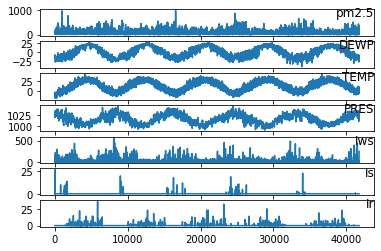

In [4]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plotting each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

# **2.** **Label** **Encoding**
The Wind direction doesn’t contain numerical values so label encoding is done.


In [5]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

# **3. Data Normalization**
Data Normalization is done using MinMaxScaler function of sklearn.

In [6]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# **4. Converting to Time Series Data**
Since we use the LSTM neural network, we must sort the data according to the time. The dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed. So, we have features for previous timestep (t-1) and for prediction of pollution PM2.5 taking its current timestep (t) data.

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002372   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003947   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005522   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008690   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.010265   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


# Splitting into train and test sets
We will only fit the model on the first 2 years(365* 24 * 2 hours) of data, then evaluate it on the remaining 3 years of data. 

In [9]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24*2
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :8], train[:, 8]
test_X, test_y = test[:, :8], test[:, 8]

# reshaping input to be 3D [samples, timesteps, features]


In [10]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17520, 1, 8) (17520,) (24236, 1, 8) (24236,)


# **Designing Network**
We will define the LSTM with 100 neurons in the first hidden layer and a Dropout Layer of 0.3,Next there will be another hidden layer of 50 neurons and a Dropout of 0.2. Similarly, there will two more hidden layers with respective 0.2 Dropouts and 50 neurons. In Final Layer, 1 neuron in the output layer for predicting pollution. In the activation Function we used linear function, because of sequential dataset. In the batch size we used three days (24*3 Hours) data. Optimizer function we used Adam method. Loss function we used mean squared error. By monitoring the value of test data loss function, stop the training model when it is not decreasing, and save the current best model.

In [11]:
# design network
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(1,activation='linear'))

model.compile(loss='mse', optimizer='adam')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            43600     
_________________________________________________________________
dropout (Dropout)            (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

# **Fitting the Network**
Network is fit with epochs size of 50 , batch size of 72.

In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 17520 samples, validate on 24236 samples
Epoch 1/50
17520/17520 - 15s - loss: 0.0073 - val_loss: 0.0060
Epoch 2/50
17520/17520 - 4s - loss: 0.0015 - val_loss: 0.0030
Epoch 3/50
17520/17520 - 4s - loss: 0.0012 - val_loss: 0.0015
Epoch 4/50
17520/17520 - 4s - loss: 0.0011 - val_loss: 8.6442e-04
Epoch 5/50
17520/17520 - 4s - loss: 0.0010 - val_loss: 7.1259e-04
Epoch 6/50
17520/17520 - 4s - loss: 9.6795e-04 - val_loss: 6.1583e-04
Epoch 7/50
17520/17520 - 4s - loss: 9.4334e-04 - val_loss: 6.4784e-04
Epoch 8/50
17520/17520 - 4s - loss: 9.2605e-04 - val_loss: 6.7361e-04
Epoch 9/50
17520/17520 - 4s - loss: 9.1633e-04 - val_loss: 6.2985e-04
Epoch 10/50
17520/17520 - 4s - loss: 9.0485e-04 - val_loss: 6.8041e-04
Epoch 11/50
17520/17520 - 4s - loss: 9.0584e-04 - val_loss: 6.5324e-04
Epoch 12/50
17520/17520 - 4s - loss: 9.0974e-04 - val_loss: 7.4297e-04
Epoch 13/50
17520/17520 - 4s - loss: 9.0971e-04 - val_loss: 7.1148e-04
Epoch 14/50
17520/17520 - 4s - loss: 8.7103e-04 - val_loss: 7.6773e

# **Plotting the graph of Train Loss and Test Loss**

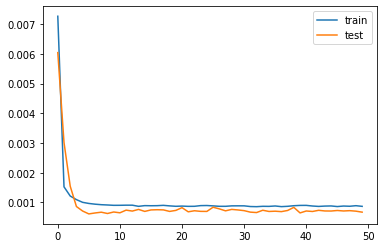

In [14]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# **Making Prediction/Forecasting**
Forecasting the results and invert the scaling of the prediction and test data to check.

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# **Calculating the RMSE and MAE values**

In [16]:
# calculate RMSE and MAE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = (mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % mae)

Test RMSE: 25.824
Test MAE: 15.698


# **Plotting the Graph of Actual vs Predicted**

Actual : [110. 113. 110. ...  10.   8.  12.]
Predicted: [107.609505  105.75443   109.01078   ...   6.453778    6.4088535
   5.190113 ]


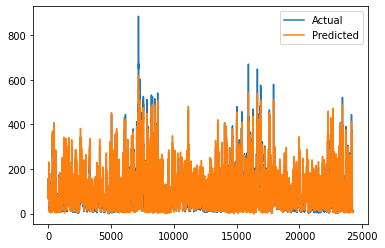

In [17]:
print('Actual :', inv_y)
print('Predicted:', inv_yhat)
# plot history
pyplot.plot(inv_y, label='Actual')
pyplot.plot(inv_yhat, label='Predicted')
pyplot.legend()
pyplot.show()